# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [209]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
        
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [202]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
            
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)

def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        #if hr_imputation:
            #high_risk_exposure_imputation(train_x, train_y, target_imputation = True)
            #high_risk_exposure_imputation(valid_x, valid_y)
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")
    return results.mean(axis=0)
    
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        if(ratio_negatives_to_positives >= 1):            
            results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
        else:
            results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
        display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))
        print("")

In [211]:
models ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=30),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(), 
    "KNN" : KNeighborsClassifier(weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [12]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 757.3 KB


In [13]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.506000,0.082656,0.562587,0.929273,0.141837
Validation,0.498777,0.076869,0.476664,0.921311,0.129985



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.510728,0.913435,0.506000,0.108091,0.650922
Validation,0.502037,0.902612,0.500921,0.100820,0.643709



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.519548,0.729798,0.533362,0.309364,0.545926
Validation,0.505724,0.707570,0.481749,0.303279,0.527337



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.516456,0.732091,0.525903,0.300818,0.548487
Validation,0.506959,0.730315,0.515002,0.283607,0.542648



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.509092,0.027278,0.753978,0.990818,0.052607
Validation,0.504500,0.020432,0.630714,0.989344,0.039318



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.513683,0.897167,0.507730,0.130273,0.648298
Validation,0.513108,0.898494,0.507575,0.127049,0.648513


In [14]:

comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.526366,0.184486,0.582944,0.868182,0.279885
Validation,0.523300,0.189691,0.563737,0.857377,0.279807



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.538593,0.771330,0.529868,0.305909,0.611390
Validation,0.521726,0.738931,0.517538,0.304098,0.587141



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.549050,0.792790,0.542770,0.305364,0.619427
Validation,0.535206,0.779768,0.537573,0.290164,0.614133



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.547232,0.870068,0.528727,0.224455,0.657648
Validation,0.533573,0.852679,0.520569,0.213934,0.645901



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.513183,0.033551,0.822208,0.992727,0.064406
Validation,0.504083,0.025337,0.547222,0.983607,0.048070



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.544276,0.656274,0.551663,0.432273,0.552200
Validation,0.526235,0.619772,0.520784,0.432787,0.522777


We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [15]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [16]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

,sys,dia,age
5135,195.0,135.0,4
6106,215.0,115.0,4
9058,200.0,120.0,3
11792,190.0,130.0,3
14314,205.0,125.0,4
19137,215.0,117.0,4
20168,190.0,130.0,4
20379,220.0,140.0,4
20582,200.0,118.0,4
28579,180.0,130.0,3


As expected, all pressure variables (including pam) are correlated between each other

In [17]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48705 entries, 0 to 93994
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  46961 non-null  float64
 1   pulse        47666 non-null  float64
 2   rr           40972 non-null  float64
 3   sats         46959 non-null  float64
 4   pam          45990 non-null  float64
dtypes: float64(5)
memory usage: 2.2 MB


<AxesSubplot:>

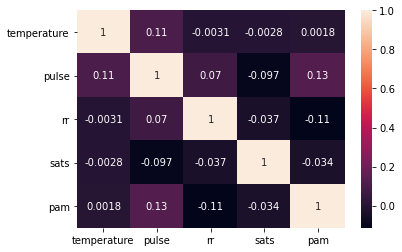

In [18]:
sns.heatmap(vitals.corr(), annot=True)

In [19]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.564651,0.530079,0.569228,0.599192,0.548949
Validation,0.560525,0.526847,0.566082,0.594495,0.544545



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662776,0.620160,0.67814,0.705354,0.647585
Validation,0.587956,0.545079,0.59496,0.631193,0.566711



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998484,0.997978,0.998990,0.99899,0.998483
Validation,0.562831,0.565079,0.564593,0.56055,0.564502



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572735,0.622584,0.566347,0.522929,0.592742
Validation,0.568309,0.613378,0.561965,0.522936,0.585005



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998535,0.997169,0.999899,0.999899,0.998532
Validation,0.524907,0.495004,0.528764,0.555046,0.510958



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.591128,0.561117,0.596898,0.621111,0.578429
Validation,0.592506,0.550509,0.599603,0.634862,0.572774


In [20]:
vitals_ex = pd.merge(vitals, e_factors, left_index=True, right_index=True)
run_models(vitals_ex, y[vitals_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570563,0.535236,0.575707,0.605859,0.554707
Validation,0.568770,0.535029,0.574872,0.602752,0.552687



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661109,0.634008,0.670557,0.688182,0.651413
Validation,0.578344,0.555113,0.581212,0.601835,0.565933



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999949,1.000000,0.999899,0.999899,0.999949
Validation,0.554143,0.542377,0.556215,0.566055,0.548419



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570815,0.588725,0.568449,0.552929,0.577835
Validation,0.567852,0.584120,0.566694,0.551376,0.573173



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999495,0.998989,1.000000,1.000000,0.999494
Validation,0.539068,0.518649,0.544163,0.559633,0.530642



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.588500,0.564150,0.592762,0.612828,0.578030
Validation,0.575598,0.557748,0.577595,0.593578,0.566357


In [21]:
vitals_comorb = pd.merge(vitals, comorb, left_index=True, right_index=True)
run_models(vitals_comorb, y[vitals_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572331,0.538571,0.577421,0.606061,0.557294
Validation,0.555942,0.530450,0.560311,0.581651,0.544261



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.640089,0.571432,0.662444,0.708687,0.613328
Validation,0.591142,0.520484,0.606902,0.662385,0.556757



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.998888,0.998686,0.999091,0.999091,0.998887
Validation,0.555521,0.539600,0.559157,0.571560,0.548956



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567126,0.543731,0.570794,0.590505,0.55641
Validation,0.549104,0.537756,0.551767,0.560550,0.54176



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999242,0.998787,0.999697,0.999697,0.999241
Validation,0.541802,0.535046,0.545579,0.548624,0.539705



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.582386,0.558084,0.586427,0.606667,0.571859
Validation,0.573315,0.547740,0.576916,0.599083,0.560133


In [22]:
vitals_comorb_ex = pd.merge(vitals_comorb, e_factors, left_index=True, right_index=True)
run_models(vitals_comorb_ex, y[vitals_comorb_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.576879,0.540896,0.582877,0.612828,0.561010
Validation,0.565557,0.515913,0.574028,0.615596,0.541848



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.647416,0.612581,0.658483,0.682222,0.634362
Validation,0.579743,0.549608,0.585021,0.610092,0.565446



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999747,0.999798,0.999697,0.999697,0.999747
Validation,0.534012,0.525913,0.535933,0.542202,0.529787



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567582,0.529268,0.573207,0.605859,0.549838
Validation,0.563278,0.525079,0.569292,0.601835,0.543621



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999697,0.999393,1.000000,1.000000,0.999697
Validation,0.538601,0.535922,0.539986,0.541284,0.537600



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.586277,0.565666,0.589868,0.606869,0.577473
Validation,0.592043,0.545038,0.602004,0.639450,0.569796


### Assesed Symptoms

In [23]:
a_symptoms.dropna(how="all", inplace=True)

In [24]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.540019,0.848467,0.524720,0.231657,0.648426
Validation,0.549699,0.848151,0.531113,0.250420,0.652979



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.589003,0.398528,0.643591,0.779423,0.492172
Validation,0.590869,0.386492,0.653217,0.795798,0.484727



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.603856,0.409706,0.669809,0.797952,0.508342
Validation,0.582879,0.387297,0.635211,0.778992,0.479643



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.549191,0.667396,0.563629,0.431006,0.554516
Validation,0.544668,0.663046,0.576220,0.426050,0.561612



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.582532,0.329435,0.667254,0.835568,0.437773
Validation,0.557292,0.300070,0.619989,0.815126,0.399307



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.544349,0.838035,0.527936,0.250745,0.647727
Validation,0.537935,0.841471,0.523582,0.233613,0.645295


In [25]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.553708,0.743217,0.538662,0.364246,0.623236
Validation,0.543001,0.730882,0.531381,0.354622,0.613906



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.602132,0.569060,0.610819,0.635196,0.587759
Validation,0.596686,0.540588,0.610464,0.652941,0.571481



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.648182,0.596544,0.669445,0.699814,0.626313
Validation,0.566508,0.504496,0.580237,0.628571,0.534046



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.565488,0.651320,0.564705,0.479702,0.590199
Validation,0.543005,0.624286,0.533587,0.461345,0.560206



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.628253,0.361085,0.775383,0.895345,0.492476
Validation,0.558540,0.281639,0.637049,0.836134,0.389272



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.567398,0.698235,0.553766,0.436592,0.615424
Validation,0.561459,0.680595,0.550739,0.442017,0.606733


In [26]:
a_symptoms_comorb = pd.merge(a_symptoms, comorb, left_index=True, right_index=True)
run_models(a_symptoms_comorb, y[a_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.546677,0.809726,0.530629,0.283706,0.640984
Validation,0.543392,0.794433,0.528620,0.291597,0.634338



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.596964,0.413241,0.653879,0.780633,0.505944
Validation,0.590450,0.408263,0.642702,0.773109,0.497391



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.622666,0.445658,0.690840,0.799628,0.541275
Validation,0.567368,0.394013,0.602112,0.741176,0.474570



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.549938,0.727099,0.556070,0.372812,0.590740
Validation,0.520759,0.689937,0.527882,0.351261,0.557455



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.604089,0.332131,0.729276,0.875978,0.454835
Validation,0.548471,0.268207,0.608025,0.829412,0.370878



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.549379,0.784949,0.533600,0.313873,0.635259
Validation,0.542975,0.769412,0.529933,0.315966,0.627390


In [27]:
a_symptoms_comorb_ef = pd.merge(a_symptoms, comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef, y[a_symptoms_comorb_ef.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.569214,0.788301,0.548124,0.350186,0.646571
Validation,0.566898,0.776870,0.547401,0.356303,0.641645



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.596313,0.500688,0.625899,0.691899,0.549047
Validation,0.583244,0.467668,0.618492,0.699160,0.523696



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.641570,0.506474,0.695684,0.776629,0.584966
Validation,0.585377,0.435805,0.625528,0.735294,0.512597



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.560926,0.635701,0.568370,0.486220,0.569965
Validation,0.536690,0.616345,0.531287,0.456303,0.540268



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.619547,0.344888,0.766769,0.894134,0.474430
Validation,0.560225,0.272381,0.635538,0.848739,0.377149



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.566374,0.752907,0.548354,0.379888,0.634415
Validation,0.555566,0.737570,0.541631,0.373109,0.623899


In [28]:
a_symptoms_comorb_ef_vitals = pd.merge(vitals, a_symptoms_comorb_ef, left_index=True, right_index=True)
run_models(a_symptoms_comorb_ef_vitals, y[a_symptoms_comorb_ef_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.579710,0.637031,0.571579,0.522414,0.602166
Validation,0.571616,0.635596,0.567112,0.507339,0.597962



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.668578,0.635312,0.680624,0.701826,0.657112
Validation,0.612735,0.578799,0.618523,0.646789,0.596931



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999696,0.999696,0.999696,0.999696,0.999696
Validation,0.572067,0.559758,0.575260,0.584404,0.566305



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572305,0.553120,0.575086,0.591481,0.563680
Validation,0.564765,0.546088,0.566750,0.583486,0.554789



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999746,0.999492,1.00000,1.000000,0.999746
Validation,0.532713,0.502185,0.53608,0.563303,0.517806



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.602129,0.597052,0.603015,0.607201,0.599946
Validation,0.585748,0.580550,0.585506,0.590826,0.579801


### Reported symptoms

In [29]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [30]:
r_symptoms.dropna(how="all", inplace=True)

In [31]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.628330,0.364246,0.772211,0.892364,0.494743
Validation,0.621196,0.357557,0.754080,0.885246,0.481810



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664696,0.492818,0.751335,0.836545,0.594862
Validation,0.650669,0.484360,0.721596,0.817213,0.577124



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.702700,0.507637,0.832636,0.897727,0.630528
Validation,0.634712,0.438545,0.718140,0.831148,0.542620



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.683107,0.499543,0.789951,0.866636,0.611656
Validation,0.652317,0.462302,0.745994,0.842623,0.567014



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.695609,0.453267,0.880333,0.937909,0.597935
Validation,0.628565,0.391064,0.744536,0.866393,0.510424



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663924,0.482451,0.757671,0.845364,0.589428
Validation,0.656807,0.471278,0.746751,0.842623,0.574986


In [32]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.623783,0.343693,0.781148,0.903818,0.476938
Validation,0.619144,0.341157,0.766566,0.897541,0.469563



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661469,0.505638,0.734664,0.817273,0.598784
Validation,0.655179,0.500746,0.720705,0.809836,0.587809



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.705337,0.509001,0.838266,0.901636,0.633254
Validation,0.630624,0.441030,0.712229,0.820492,0.542282



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.686562,0.505911,0.792371,0.867182,0.617315
Validation,0.642076,0.465560,0.719502,0.818852,0.562040



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.695881,0.450080,0.885700,0.941636,0.596455
Validation,0.632235,0.385333,0.757094,0.879508,0.509290



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663241,0.478720,0.758784,0.847727,0.586952
Validation,0.660498,0.474544,0.751381,0.846721,0.578509


In [33]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.613510,0.323695,0.770078,0.903273,0.455683
Validation,0.606434,0.315767,0.750056,0.897541,0.442584



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661923,0.502637,0.737856,0.821182,0.597747
Validation,0.648220,0.502386,0.708411,0.794262,0.583766



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.697745,0.500362,0.826839,0.895091,0.623304
Validation,0.646587,0.446721,0.741054,0.846721,0.554610



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.686244,0.508274,0.789827,0.864182,0.618155
Validation,0.656420,0.473790,0.744662,0.839344,0.577398



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.690245,0.452263,0.863276,0.928182,0.593330
Validation,0.637999,0.388658,0.776728,0.887705,0.515668



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662741,0.483995,0.753105,0.841455,0.589203
Validation,0.659269,0.475357,0.749443,0.843443,0.578834


In [34]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.645900,0.501165,0.705439,0.790596,0.585929
Validation,0.646278,0.489608,0.710924,0.803361,0.577702



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.664059,0.538231,0.719276,0.789851,0.615637
Validation,0.655063,0.530623,0.707074,0.779832,0.600850



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.760023,0.584987,0.900074,0.935009,0.708994
Validation,0.643736,0.467738,0.723476,0.820168,0.564520



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.652140,0.444356,0.761002,0.859870,0.560672
Validation,0.644142,0.429139,0.747103,0.859664,0.541139



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.756251,0.546613,0.941175,0.965829,0.691467
Validation,0.638281,0.430903,0.733705,0.846218,0.539818



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.670810,0.511978,0.752254,0.829609,0.608302
Validation,0.662603,0.499503,0.742041,0.826050,0.591651


In [35]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.643467,0.467539,0.721213,0.819364,0.567252
Validation,0.637596,0.465654,0.706105,0.809836,0.558774



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662697,0.511456,0.733365,0.813909,0.602546
Validation,0.658075,0.505664,0.725512,0.810656,0.592640



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.750296,0.565466,0.897437,0.935091,0.693588
Validation,0.630601,0.450053,0.703932,0.811475,0.548228



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.672925,0.485906,0.776304,0.859909,0.597574
Validation,0.658451,0.468806,0.752491,0.848361,0.572900



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.748204,0.523639,0.950539,0.972727,0.675209
Validation,0.620786,0.386192,0.726380,0.855738,0.501331



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662423,0.509729,0.736232,0.815091,0.601144
Validation,0.651897,0.501559,0.717232,0.802459,0.587153


In [36]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.66030,0.521483,0.721678,0.798990,0.605406
Validation,0.64872,0.514170,0.702993,0.784404,0.590877



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.690566,0.587906,0.739829,0.793131,0.654944
Validation,0.650054,0.555963,0.685916,0.744954,0.611651



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999495,0.999191,0.999798,0.999798,0.999494
Validation,0.624968,0.604187,0.634817,0.645872,0.617034



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.570664,0.555459,0.572821,0.585859,0.563387
Validation,0.562825,0.551410,0.564832,0.574312,0.556327



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999798,0.999596,1.000000,1.000000,0.999798
Validation,0.549101,0.462227,0.562977,0.636697,0.506472



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.676873,0.554644,0.734128,0.798990,0.631659
Validation,0.655557,0.539616,0.705911,0.772477,0.608966


In [37]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.657672,0.526332,0.714031,0.788945,0.605840
Validation,0.646709,0.512344,0.700233,0.781651,0.589927



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.695612,0.609233,0.736480,0.781947,0.666749
Validation,0.660389,0.573411,0.694326,0.747706,0.625640



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999848,0.999797,0.999899,0.999899,0.999848
Validation,0.612352,0.581735,0.620409,0.643119,0.600054



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.572253,0.560726,0.573945,0.583773,0.567120
Validation,0.563391,0.555279,0.562568,0.571560,0.557708



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999746,0.999493,1.000000,1.000000,0.999746
Validation,0.553335,0.474028,0.564857,0.633028,0.514412



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.675678,0.557885,0.730300,0.793408,0.632262
Validation,0.670485,0.548857,0.724192,0.792661,0.622667


In [38]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.640967,0.411620,0.760571,0.870273,0.533864
Validation,0.635930,0.405798,0.751076,0.866393,0.523082



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662015,0.505999,0.735524,0.818000,0.599328
Validation,0.665420,0.502399,0.742738,0.828689,0.596604



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.713338,0.529369,0.837814,0.897273,0.648604
Validation,0.646977,0.462242,0.730067,0.831967,0.563945



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.697336,0.521002,0.804949,0.873636,0.63247
Validation,0.654379,0.481168,0.735893,0.827869,0.57953



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.709564,0.471355,0.900983,0.947727,0.618356
Validation,0.627785,0.387931,0.745149,0.868033,0.508976



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663742,0.503276,0.743863,0.824182,0.599200
Validation,0.650266,0.494189,0.717776,0.806557,0.581611


In [39]:
all_data = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms_comorb_ef_vitals, left_index=True, right_index=True)
run_models(all_data, y[all_data.index], models, ratio_negatives_to_positives=1)

MultinomialNB
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.661019,0.546320,0.708953,0.775659,0.616999
Validation,0.670908,0.539708,0.733079,0.802752,0.620403



Random Forest (100 estimators)
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.690490,0.590260,0.738229,0.790669,0.655912
Validation,0.671377,0.561526,0.719247,0.781651,0.628082



XGBoost Classifier
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999949,1.000000,0.999899,0.999899,0.999949
Validation,0.622892,0.605471,0.631031,0.640367,0.616269



SVM
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.574182,0.558298,0.576478,0.590061,0.567009
Validation,0.580300,0.556989,0.583334,0.603670,0.568001



KNN
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.999899,0.999797,1.000000,1.000000,0.999898
Validation,0.542367,0.450267,0.552673,0.634862,0.495557



Logistic Regression
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.682526,0.585995,0.726447,0.779006,0.648517
Validation,0.667272,0.557990,0.716174,0.777064,0.624934


In [40]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [41]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [186]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [187]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.674425,0.541101,0.740861,0.807727,0.623833
Validation,0.641685,0.508137,0.696415,0.775410,0.581760


In [189]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [196]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



In [181]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

Ada
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.684201,0.592083,0.725927,0.776268,0.652092
Validation,0.667727,0.582585,0.701879,0.753211,0.635613


In [222]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

LogisticVanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.676334,0.574742,0.721386,0.777909,0.639712
Validation,0.664199,0.546528,0.713292,0.781967,0.616991



LogisticStrongRegularization
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.674878,0.576739,0.717672,0.773000,0.639474
Validation,0.666636,0.553099,0.717618,0.780328,0.623166



LogisticWeakRegularization
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.676334,0.578469,0.719272,0.774182,0.641140
Validation,0.662958,0.555538,0.707213,0.770492,0.620579



LogiscticAdaBoost
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.675652,0.581830,0.716342,0.769455,0.642023
Validation,0.660903,0.562102,0.698600,0.759836,0.620982


In [226]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

In [227]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.690926,0.598197,0.734556,0.783636,0.659202
Validation,0.669512,0.563695,0.716321,0.775410,0.629278



Ada Logistic
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.679106,0.590923,0.717454,0.767273,0.648001
Validation,0.676462,0.583327,0.715407,0.769672,0.640738



Ada algo
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.676697,0.607479,0.706529,0.745909,0.652055
Validation,0.665005,0.589051,0.697290,0.740984,0.636671



Ada learning rate
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.687289,0.585651,0.735413,0.788909,0.651777
Validation,0.663346,0.563688,0.702216,0.763115,0.623566



Ada complete
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.663289,0.62466,0.677434,0.701909,0.649514
Validation,0.652718,0.59896,0.670579,0.706557,0.630207


In [228]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.698910,0.606491,0.744168,0.791278,0.668157
Validation,0.662232,0.567973,0.701288,0.756881,0.624897



Ada Logistic
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.680446,0.583966,0.723627,0.776876,0.646250
Validation,0.673681,0.573486,0.717740,0.774312,0.635708



Ada algo
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.682932,0.595636,0.723316,0.770183,0.651961
Validation,0.662228,0.567973,0.705029,0.756881,0.624902



Ada learning rate
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.693076,0.577978,0.750701,0.808114,0.653044
Validation,0.667276,0.544245,0.720518,0.790826,0.618108



Ada complete
╠■■■■■■■■■╣


,Accuracy,Recall,Precision,Specificity,F1
Training,0.662744,0.634803,0.672512,0.690669,0.652992
Validation,0.660865,0.617314,0.677720,0.704587,0.645351


In [111]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(ra_symptoms_vitals, y[ra_symptoms_vitals.index])
lr.fit(ra_symptoms_vitals, y[ra_symptoms_vitals.index], sample_weight=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative")))

LogisticRegression()

In [156]:
cross_validation_normal(ra_symptoms_vitals, y[ra_symptoms_vitals.index], )

(3, 10)